# Training a SimpleUnet on SWISEG
> training and assessing model perf using wandb

Let's make a Custom Unet that is `torch.jit.script`-able, to do so, we need to make the code very clean, without using the magic behind fastai's `SequentialEx` and removing the `Hooks` that are put on the encoder, and recover the shortcuts on the UNET by hand.

In this notebooks we will explore cloud public datasets and implement some basic deep learning pipelines
- One initial resource will be [WSISEG-Database](https://github.com/CV-Application/WSISEG-Database)

The database contains 400 uncropped whole sky images and corresponding labels. In these annotation images, cloud, clear sky and undefined area are marked with gray value 255, 100, 0 respectively.

 The original [paper](https://www.atmos-meas-tech.net/13/1953/2020/amt-13-1953-2020.pdf) that introduces the dataset.

We will first download the dataset and import the deep learning Libraries for the task.

In [86]:
import wandb
from fastai.callback.wandb import WandbCallback

from fastai.basics import *
from fastai.vision.all import *

from dl_lib.all import *

torch.backends.cudnn.benchmark = False

> Note: I have put a set of scripts on the `dl_lib` folder to make the code more readable. Includes some handy tools like `is_gpu`:

In [87]:
is_gpu(0)

0: *Quadro RTX 8000,         48.6GB, tensor_cores=72
1: Quadro RTX 8000,         48.6GB, tensor_cores=72


True

In [88]:
# %pip install wandb -Uqq

In [89]:
wandb.init(project='cloud-segmentation',
          config={
          "model": 'SimpleUnet',
          "model_layers": [32, 64, 96, 128],
          "model_sa": True,
          "epochs": 12,
          "seed": 5150,
          "image_size": 256,
      })

beta_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dice_multi,▁▅▅▇▇▇▇█████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
foreground_acc,▁▅▅▇█▇██████
lr_0,████████████████████████████████▇▆▅▄▃▂▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▃▄▂▂▂▂▁▁▁▁▁


In [90]:
config = wandb.config
config

{'model': 'SimpleUnet', 'model_layers': [32, 64, 96, 128], 'model_sa': True, 'epochs': 12, 'seed': 5150, 'image_size': 256}

In [91]:
set_seed(config.seed)

## Setup

Let's grab the data from the WSISEG repo

In [92]:
PATH = Path.cwd().parent/'WSISEG-Database'
get_wsiseg(PATH, sizes=[128, 256])

### Check Dataset Images
> Some basic checkup of x,y

In [93]:
size = config.image_size
image_path = PATH/f'images{size}'
mask_path = PATH/f'masks{size}'

In [94]:
files = get_image_files(image_path)
files

(#400) [Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256/ASC100-1006_264.png'),Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256/ASC100-1006_191.png'),Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256/ASC100-1006_314.png'),Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256/ASC100-1006_392.png'),Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256/ASC100-1006_270.png'),Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256/ASC100-1006_363.png'),Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256/ASC100-1006_307.png'),Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256/ASC100-1006_150.png'),Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256/ASC100-1006_257.png'),Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256/ASC100-1006_211.png')...]

Let's take a look at one image:

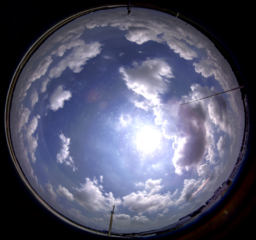

In [95]:
im = load_image(files[0])
im

In [96]:
im.shape

(240, 256)

In [97]:
mask_path.ls()[0]

Path('/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/masks256/ASC100-1006_264.png')

The masks are called identically but place on the respective `masks` folder

In [98]:
def label_func(fn): 
    folder = fn.parent.name.replace('images', 'masks')
    return (fn.parent.parent/folder)/fn.name

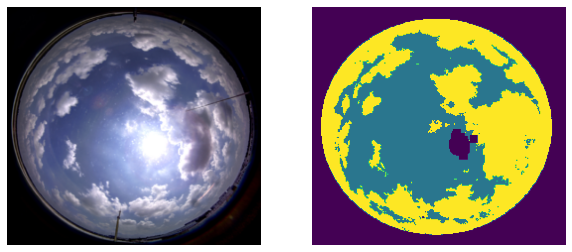

In [99]:
mask = PILMask.create(label_func(files[0]))
show_images([im, mask], figsize=(10,5))

##  DataBlock:
We can also use the data block API to get our data in a `DataLoaders`. 

In this case we build the data block by providing:

- the types used: `ImageBlock` and `MaskBlock`.
- how to gather our items, here by using `get_image_files`.
- how to get the targets from our items: by using `label_func`.
- how to split the items, here randomly.
- `batch_tfms` for data augmentation. 

The DataBlock is a pipeline to transform a source.

In [100]:
def get_block(bs=16, val_n=50, tfms=aug_transforms(pad_mode='zeros')):
    "Get segmentation datablock"
    block = DataBlock(blocks=(ImageBlock, MaskBlockCustom), 
                  get_items=get_image_files,
                  get_y=label_func,
                  batch_tfms=tfms + [Normalize.from_stats(*WSISEG_STATS)],
                  splitter=IndexSplitter(list(range(400-val_n, 400))),
                  )
    return block

In [101]:
def get_dls(size=128, bs=16, val_n=50):
    "Get a dataloader with correspoding image sizes, set size=None for full size"
    block = get_block(bs, val_n)
    size = ifnone(size, '')
    if size not in ['', 128, 256]:
        print('Please choose a size in [128, 256], else set to None')
    image_path = PATH/f'images{size}'
    print(f'Reading images from: {image_path}')
    return block.dataloaders(image_path, bs=bs)

In [102]:
dls = get_dls(256)

Reading images from: /home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256


we can easily show one batch of images;

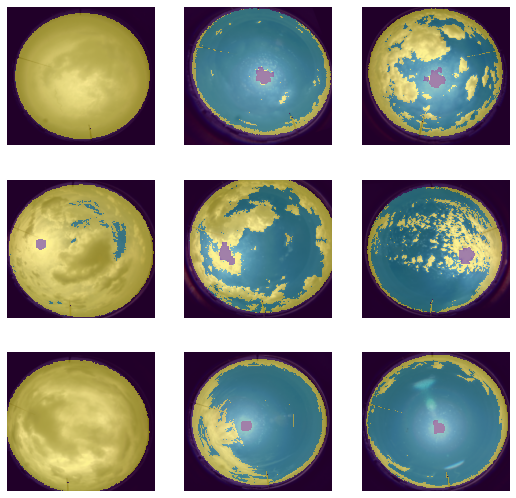

In [103]:
dls.show_batch(cmap='viridis')

In [104]:
x,y = dls.one_batch()

In [105]:
y.unique()

TensorMask([0, 1, 2], device='cuda:0')

## Train
> My super simple UNET

We build a simple UNET but using all the tricks from fastai (blur, pixelshuffle upsample, self attention, xresnet blocks). We can build very simple UNET, with a small encoder and still get excellent performance.

In [106]:
loss_func = FocalLossFlat(axis=1)
metrics   = [foreground_acc, DiceMulti()]

the code for this `SimpleUnet` can be found under `dl_lib/segmentation.py`

In [107]:
model = SimpleUnet(n_classes=3, sa=config.model_sa, l_szs=config.model_layers).cuda()

In [108]:
learn = Learner(dls, 
                model, 
                metrics=metrics, 
                loss_func=loss_func,
                opt_func=ranger,
                path = Path.cwd().parent,
                model_dir = 'model_checkpoints',
                cbs = [SaveModelCallback(monitor='foreground_acc', fname=f'{config.model}'), 
                       WandbCallback(log_dataset=PATH, 
                                     dataset_name='WSISEG', 
                                     seed=config.seed)]).to_fp16()

In [109]:
learn.fit_flat_cos(config.epochs, 5e-3)

wandb: Adding directory to artifact (/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images256)... Done. 0.0s
wandb: Adding directory to artifact (/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images128)... Done. 0.0s
wandb: Adding directory to artifact (/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/masks)... Done. 0.0s
wandb: Adding directory to artifact (/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/masks256)... Done. 0.0s
wandb: Adding directory to artifact (/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/images)... Done. 0.1s
wandb: Adding directory to artifact (/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/masks128)... Done. 0.0s
wandb: Adding directory to artifact (/home/tcapelle/Documents/cloud_segmentation/WSISEG-Database/.git)... Done. 0.1s


epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.340328,0.164127,0.783238,0.851469,00:04
1,0.196584,0.094839,0.858584,0.900628,00:04
2,0.141138,0.092510,0.876907,0.912617,00:05
3,0.112120,0.063653,0.903193,0.931125,00:05
4,0.095786,0.051560,0.932726,0.946461,00:04
5,0.082300,0.050368,0.927527,0.947612,00:05
6,0.073080,0.046577,0.941266,0.951315,00:04
7,0.067013,0.044337,0.938788,0.952886,00:05
8,0.060813,0.041732,0.939329,0.954176,00:05
9,0.056812,0.037819,0.947852,0.959169,00:05


Better model found at epoch 0 with foreground_acc value: 0.7832381725311279.
Better model found at epoch 1 with foreground_acc value: 0.858583927154541.
Better model found at epoch 2 with foreground_acc value: 0.8769070506095886.
Better model found at epoch 3 with foreground_acc value: 0.9031928181648254.
Better model found at epoch 4 with foreground_acc value: 0.9327256083488464.
Better model found at epoch 6 with foreground_acc value: 0.9412660002708435.
Better model found at epoch 9 with foreground_acc value: 0.9478519558906555.


we get pretty descent accuracy without overfitting.

In [110]:
def save_jit(learn, name):
    model_script = torch.jit.script(learn.model)
    name = str(Path(name).with_suffix('.jit'))
    jit_path = learn.path/learn.model_dir/name
    
    print(f'Saving torchscripted model at: {jit_path}')
    model_script.save(str(jit_path))
    
    print('Uploading .jit to wandb')
    artifact_model = wandb.Artifact(name=name, 
                                    type='model', 
                                    metadata={'torchscript':True, 'layers': config.model_layers, 'self_attention': config.model_sa}, 
                                    description='A simplified UNET based on fastai exported to torchscript')
    with artifact_model.new_file(name, mode='wb') as fa:
        fa.write(jit_path.read_bytes())
    wandb.run.log_artifact(artifact_model)

Let's save a torchscript compatible verison of our model:

In [111]:
name = 'baseline_unet'

save_jit(learn, name)

Saving torchscripted model at: /home/tcapelle/Documents/cloud_segmentation/model_checkpoints/baseline_unet.jit
Uploading .jit to wandb
